In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Loading Data

Let's again work with the FEI faces database.

In [2]:
IMG_FOLDER = Path("/home/jpsrocha/Documents/Data/FEI_faces_norm/")
IMG_FILES = sorted(IMG_FOLDER.glob("*jpg"))
FIG_FOLDER = Path("../res/ML_Exercises/GB500/exercise_list_3/report/figures/")

imgs = []

for img in IMG_FILES:
    imgs.append(plt.imread(img).reshape(1, -1))  # Loading and reshaping

X = np.vstack(imgs)

del imgs  # Deleting images to save space

Y = np.array([1 if path.name.split(".")[0][-1] == "b" else 0 for path in IMG_FILES])

# Exploring LDA with sklearn

In [3]:
lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X, Y)

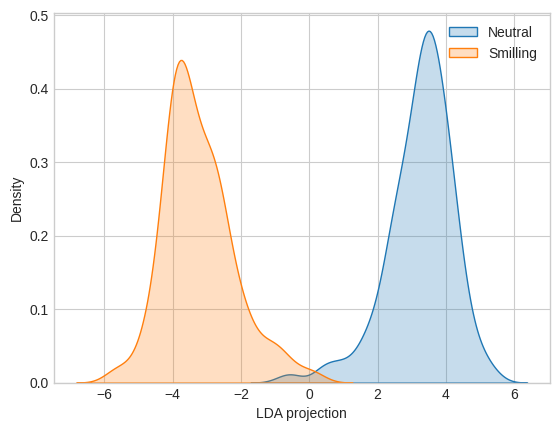

In [4]:
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")


ax = sns.kdeplot((X_lda[Y.astype("bool")]).ravel(), label="Neutral", fill=True, lw=1)
sns.kdeplot((X_lda[~Y.astype("bool")]).ravel(), label="Smilling", ax=ax, fill=True, lw=1)

ax.set(xlabel="LDA projection")


plt.legend()
plt.savefig(FIG_FOLDER / "q3_a_proj_lda.png", dpi=100)

In [5]:
X_lda.ravel()[Y.astype("bool")].shape

(200,)

# Combining LDA + Linear SVM

Now let's do one more step and use an SVM to do classification

In [6]:
pipeline = make_pipeline(
    LinearDiscriminantAnalysis(),
    LinearSVC(),
)

pipeline.fit(X, Y)

Pipeline(steps=[('lineardiscriminantanalysis', LinearDiscriminantAnalysis()),
                ('linearsvc', LinearSVC())])

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = pipeline.predict(X).astype("bool")

accuracy_score(Y, y_pred)

0.99

In [8]:
print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



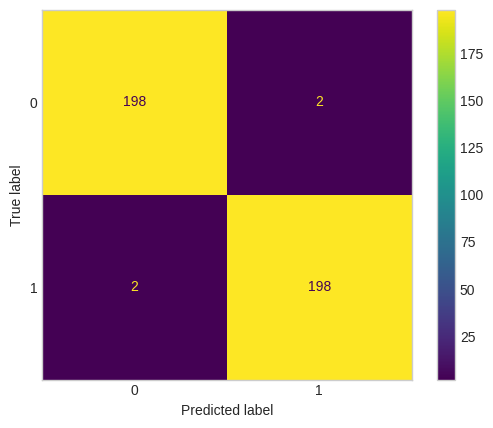

In [9]:
plt.style.use("seaborn-v0_8-whitegrid")

ax = ConfusionMatrixDisplay(confusion_matrix(Y, y_pred)).plot()

ax.ax_.grid(False)

# K-Fold cross validation

In [10]:
def new_lda_classifier():
    return make_pipeline(
        LinearDiscriminantAnalysis(),
        LinearSVC(),
    ) 

In [13]:
from sklearn.model_selection import KFold, train_test_split

def kf_classifier_cross_val(model_factory, X, Y, k=4, plot_filename=None) -> tuple[float, float]:
    """Function to make cross validation reutilizable"""

    # Starting auxiliar variables
    kf = KFold(k, random_state=42, shuffle=True)
    models = []
    accuracies = []

    if plot_filename:
        fig, axes = plt.subplots(nrows=2, ncols=2)
        

    # Training on each fold
    for i, (train_i, test_i) in enumerate(kf.split(X, Y), start=1):
        
        models.append(
            model_factory().fit(X[train_i], Y[train_i])
        )
        
        accuracies.append(models[-1].score(X[test_i], Y[test_i]))

        # Plot if necessary
        if plot_filename:
            ax = axes.ravel()[i-1]
            ConfusionMatrixDisplay(confusion_matrix(models[-1].predict(X[test_i]), Y[test_i])).plot(ax=ax)
            ax.set_title(f"K={i}")
            ax.grid(False)        

        
    if plot_filename:
        plt.tight_layout()
        plt.savefig(FIG_FOLDER / plot_filename, dpi=100)
        plt.show()
        
        
    return np.mean(accuracies).item(), np.std(accuracies).item(), accuracies

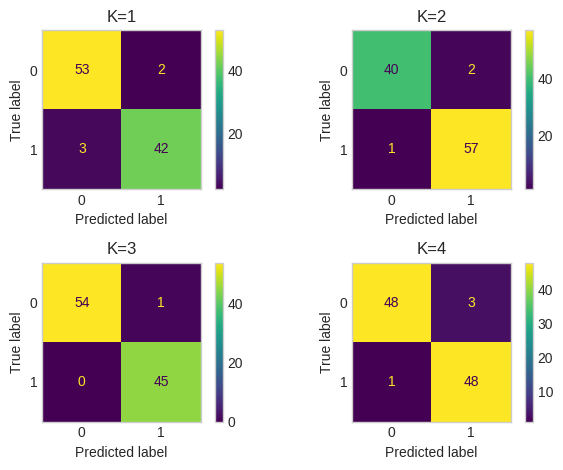

In [14]:
mu, std, acc_a = kf_classifier_cross_val(new_lda_classifier, X, Y, plot_filename="q3_a_cross_val.png")

In [15]:
mu, std, acc_a

(0.9675, 0.014790199457749054, [0.95, 0.97, 0.99, 0.96])